# Causal Relationship Discovery

## 1. Setup and Data Preparation
This section imports necessary libraries and custom functions for data preprocessing, plotting, causal discovery, and evaluation.


In [1]:
import pandas as pd
import numpy as np
import time

print([np.__version__, pd.__version__])
np.set_printoptions(precision=3, suppress=True)


from src.data_preprocessing import preprocess_data
from src.plotting import plot_time_series, plot_heatmap, plot_causal_graph
from src.causal_matrix_evaluation import evaluate_causal_matrices, interpret_evaluation_metrics
from src.run_causal_discovery import run_varlingam, run_pcmci, run_varlingam_bootstrap
from src.robust_varlingam import run_rcv_varlingam
from src.robust_pcmci import run_rcv_pcmci

['1.24.4', '2.0.3']


## 2. Causal Discovery Algorithms and Execution
Here we introduce and execute our causal discovery algorithms to get the correlation matrices and visualise the results.

### 2.1 VAR-LiNGAM (Vector Autoregressive Linear Non-Gaussian Acyclic Model)
VAR-LiNGAM is a causal discovery algorithm that estimates a linear non-Gaussian acyclic model from time series data. It is based on the principle of independent component analysis (ICA) and is designed to identify the causal relationships between variables in a multivariate time series.

### 2.2 PCMCI (Peter and Clark Momentary Conditional Independence)
PCMCI is a causal discovery algorithm that estimates causal relationships between variables in a multivariate time series using conditional independence tests. It is based on the principle of Granger causality and can identify both linear and non-linear causal relationships.



1. Loading, plotting, and preprocessing data...
Dataset shape: (1000, 5)


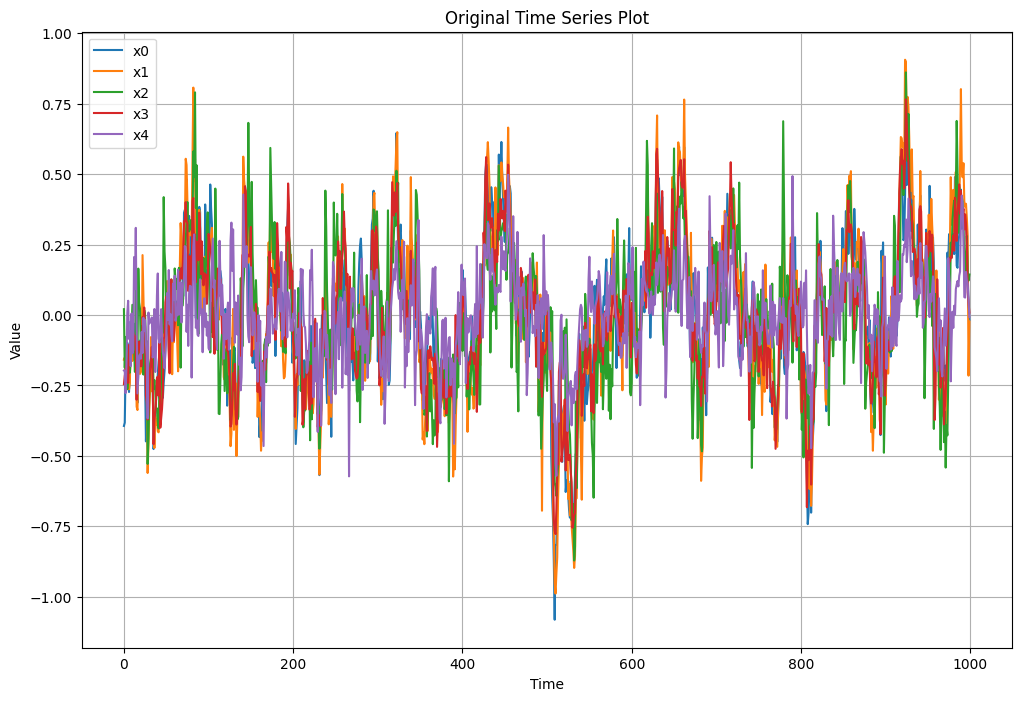


2. Running causal discovery method...

3. Printing results...
Adjacency matrices: [array([[ 0.   ,  0.   ,  0.   ,  0.678,  0.   ],
       [ 0.411,  0.   ,  0.281,  0.22 ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.396,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.221, -0.088,  0.   ,  0.   ]]), array([[ 0.419,  0.   , -0.183,  0.   ,  0.091],
       [ 0.   ,  0.265,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.536,  0.   ,  0.   ],
       [ 0.165,  0.139,  0.   ,  0.632, -0.122],
       [ 0.   ,  0.   , -0.182,  0.223,  0.381]])]
Execution time: 0.6386189460754395 seconds

4. Visualizing results...


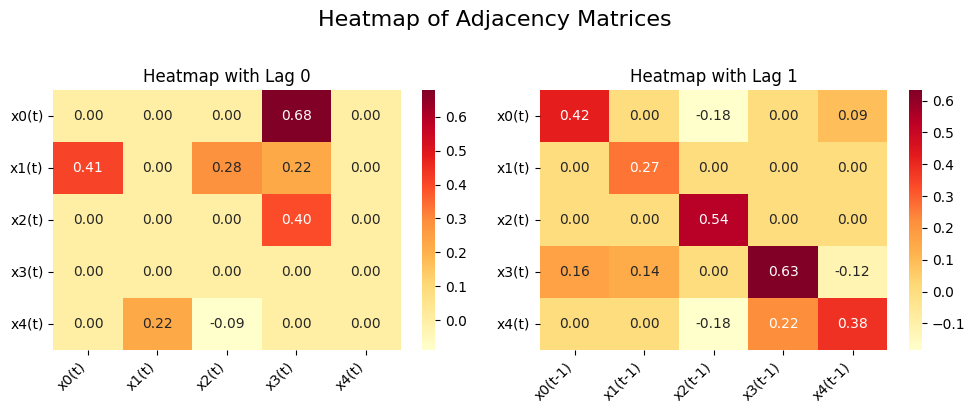

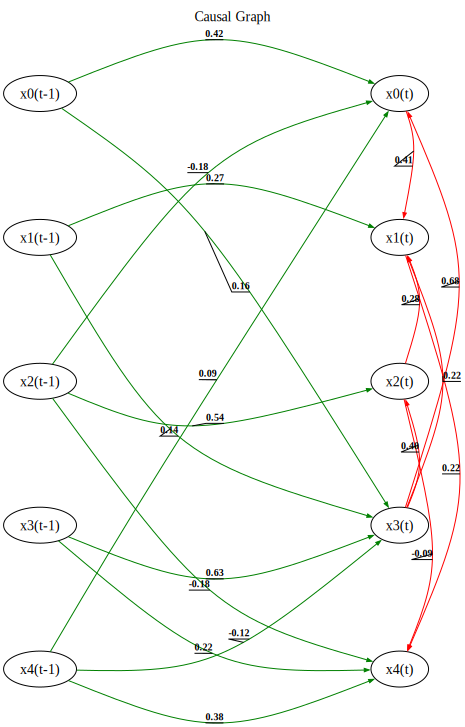

In [4]:
# 1. Load, plot, and preprocess data
print("\n1. Loading, plotting, and preprocessing data...")
data = pd.read_csv('data/artificial/test_data.csv')
columns = data.columns.tolist()
if "Date" in columns:
    data = data.drop(['Date'], axis=1).values
    columns.remove('Date')
else:
    data = data.values
print("Dataset shape:", data.shape)

# Plot original time series
plot_time_series(data, columns, title="Original Time Series Plot")

# Preprocess data
log_vars = None
percent_vars = None
# Uncomment below lines if you want to apply transformations
# log_vars = ['C', 'I', 'Y', 'P']     # Variables to log-transform
# percent_vars = ['U', 'R']         # Variables to convert to percentages
data = preprocess_data(data, columns, log_vars=log_vars, percent_vars=percent_vars)

# 2. Run causal discovery method
print("\n2. Running causal discovery method...")
method = "rcv_varlingam"  # Choose from: 'varlingam', 'pcmci', 'varlingam_bootstrap', 'rcv_varlingam', 'rcv_pcmci'

start_time = time.time()

if method == 'varlingam':
    results = run_varlingam(data)
    adjacency_matrices = results.adjacency_matrices_
elif method == 'pcmci':
    adjacency_matrices = run_pcmci(data, columns)
elif method == 'varlingam_bootstrap':
    adjacency_matrices = run_varlingam_bootstrap(data, lags=5, n_sampling=10, variance_threshold=0.1, occurrence_threshold=0.6)
elif method == 'rcv_varlingam':
    adjacency_matrices = run_rcv_varlingam(data, n_splits=7, consistency_threshold=0.7, stability_threshold=0.4, adjustment_weight=0.1)
elif method == 'rcv_pcmci':
    adjacency_matrices = run_rcv_pcmci(data, n_splits=3, consistency_threshold=0.1, stability_threshold=0.1, adjustment_weight=0.1)
else:
    print("Invalid method chosen")
    exit()

end_time = time.time()

# 3. Print results and execution time
print("\n3. Printing results...")
print("Adjacency matrices:", adjacency_matrices)
print(f"Execution time: {end_time - start_time} seconds")

# 4. Visualize results
print("\n4. Visualizing results...")
plot_heatmap(adjacency_matrices, columns)
causal_graph = plot_causal_graph(adjacency_matrices, node_labels=columns)
display(causal_graph)

## 3. Model Evaluation 
This section focuses on evaluating our causal discovery algorithms using frobenius norm, structural hamming distance, and precision-recall metrics.


Evaluating causal discovery results...

Causal Discovery Evaluation Results:
True combined: 
 [[ 0.    0.    0.    0.7   0.    0.4   0.   -0.2   0.    0.1 ]
 [ 0.4   0.    0.3   0.    0.    0.    0.3   0.    0.15  0.  ]
 [ 0.1   0.    0.    0.2   0.   -0.1   0.2   0.5   0.    0.  ]
 [-0.2   0.3   0.    0.    0.    0.2   0.    0.    0.6  -0.1 ]
 [ 0.    0.2  -0.1   0.    0.    0.    0.   -0.15  0.2   0.4 ]]
Est combined: 
 [[ 0.     0.     0.     0.678  0.     0.419  0.    -0.183  0.     0.091]
 [ 0.411  0.     0.281  0.22   0.     0.     0.265  0.     0.     0.   ]
 [ 0.     0.     0.     0.396  0.     0.     0.     0.536  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.165  0.139  0.     0.632 -0.122]
 [ 0.     0.221 -0.088  0.     0.     0.     0.    -0.182  0.223  0.381]]
SHD:  8.0
Total elements:  23.0
SHD ratio:  0.34782608695652173
[Frobenius Norm] Good: 0.573. Reasonable match between true and estimated matrices.
[Structural Hamming Distance] Good: 8.0 (34.78%). Some stru

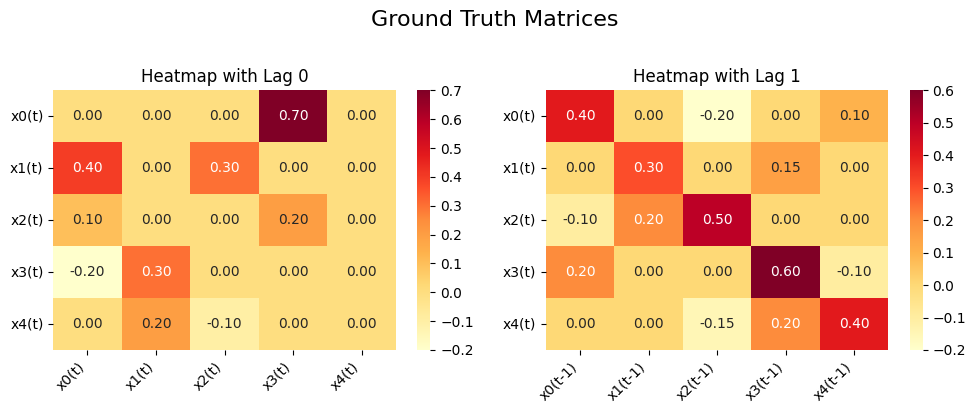

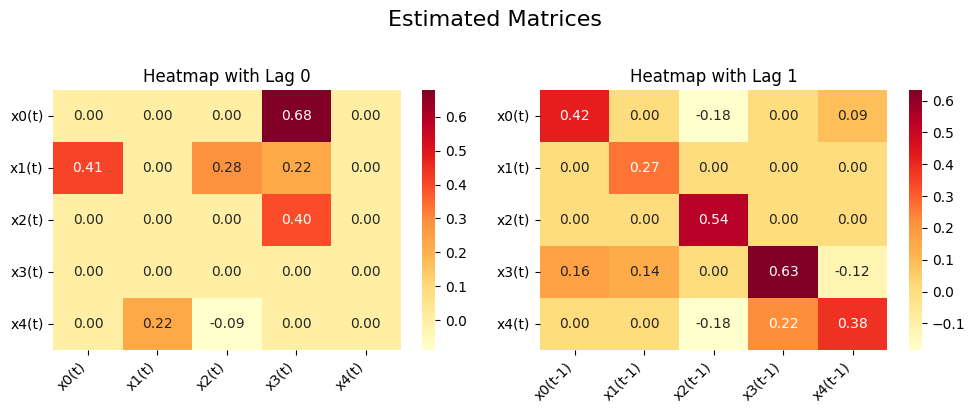

In [5]:
print("\nEvaluating causal discovery results...")

# Define ground truth matrices
B0_true = np.array([
    [ 0,    0,    0,    0.7,    0   ],
    [ 0.4,  0,    0.3,    0,    0   ],
    [ 0.1,  0,    0,  0.2,  0   ],
    [-0.2,  0.3,  0,    0,    0   ],
    [ 0,    0.2, -0.1,  0,    0   ]
])

B1_true = np.array([
    [ 0.4,  0,   -0.2,  0,    0.1],
    [ 0,    0.3,  0,    0.15, 0  ],
    [-0.1,  0.2,  0.5,  0,    0  ],
    [ 0.2,  0,    0,    0.6, -0.1],
    [ 0,    0,   -0.15, 0.2,  0.4]
])

ground_truth_matrices = [B0_true, B1_true]

# Evaluate causal discovery results
print("\nCausal Discovery Evaluation Results:")
evaluation_results = evaluate_causal_matrices(ground_truth_matrices, adjacency_matrices)
result_interpretations = interpret_evaluation_metrics(evaluation_results)

# Print evaluation results
for metric, interpretation in result_interpretations.items():
    print(f"[{metric}] {interpretation}")

# 6. Visualize comparison (optional)
print("\n6. Visualizing comparison...")
plot_heatmap(ground_truth_matrices, columns, title="Ground Truth Matrices")
plot_heatmap(adjacency_matrices, columns, title="Estimated Matrices")